In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lec3_graphs as afx
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('seaborn')

In [2]:
def bayes_solver(likelihood = .95, prior=0.01 , evidence=0.1): #asumimos, hay 95% de posibilidades de que una persona sonria a la que le gusta, prior es la posibilidad de que la persona que le gusta, le gusta a la otra al azar; evidence = probabilidad de que esa persona le guste una al azar
    return round(likelihood*prior/evidence,3)

In [3]:
bayes_solver()

0.095

In [4]:
bayes_solver(evidence = .20)#probabilidades de que yo le guste a una persona que sonrie mas de lo normal disminuye a un 5%

0.047

In [5]:
bayes_solver(prior=0.2 , evidence=.20)

0.95

In [6]:
#se hace con una medicion bernulli
df = pd.read_csv('ucbadmissions.csv').drop(columns='Unnamed: 0')

In [7]:
df.head()

,Admit,Gender,Dept,Freq
0,Admitted,Male,A,512
1,Rejected,Male,A,313
2,Admitted,Female,A,89
3,Rejected,Female,A,19
4,Admitted,Male,B,353


In [8]:
df_deagg = afx.deaggregate_statistics(df)

In [9]:
df_deagg.shape

(4526, 3)

In [10]:
df_deagg.head()

,Admit,Gender,Dept
0,Admitted,Male,A
1,Admitted,Male,A
2,Admitted,Male,A
3,Admitted,Male,A
4,Admitted,Male,A


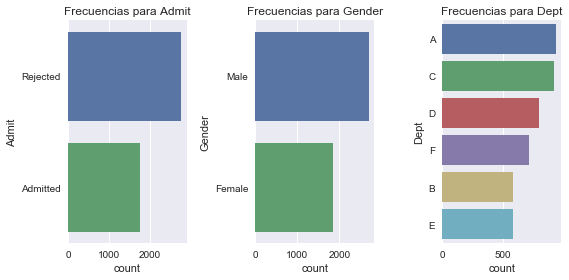

In [11]:
plt.figure(figsize=(8,4))

for n,i in enumerate(['Admit','Gender','Dept']):
    plt.subplot(1,3,n+1)
    sns.countplot(y=df_deagg[i], order=df_deagg[i].value_counts().index)
    plt.title('Frecuencias para {}'.format(i))
    plt.tight_layout()

In [12]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [13]:
lbl = LabelEncoder()
df_deagg['Gender'] = lbl.fit_transform(df_deagg['Gender'])
df_deagg['Admit'] = lbl.fit_transform(df_deagg['Admit'])
df_deagg = pd.concat([df_deagg, pd.get_dummies(df_deagg['Dept'], prefix='dept')], axis=1).drop(columns='Dept')


In [14]:
df_deagg.head()

,Admit,Gender,dept_A,dept_B,dept_C,dept_D,dept_E,dept_F
0,0,1,1,0,0,0,0,0
1,0,1,1,0,0,0,0,0
2,0,1,1,0,0,0,0,0
3,0,1,1,0,0,0,0,0
4,0,1,1,0,0,0,0,0


In [15]:
X_train , X_test, y_train, y_test = train_test_split(df_deagg.loc[:, 'Gender':'dept_F'], df_deagg['Admit'], test_size=.30, random_state=11238)

In [16]:
X_test.shape[0] / df_deagg.shape[0]

0.30004418912947417

In [17]:
nb_classifier = BernoulliNB()

In [18]:
nb_classifier.fit(X_train,y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [20]:
nb_log_prob_pred = nb_classifier.predict_log_proba(X_test)

In [21]:
nb_log_prob_pred[:10]

array([[-0.46562497, -0.9881699 ],
       [-1.38216456, -0.28906247],
       [-1.38216456, -0.28906247],
       [-1.38216456, -0.28906247],
       [-0.27100456, -1.43806365],
       [-0.3469162 , -1.22712052],
       [-0.3469162 , -1.22712052],
       [-1.70094765, -0.2015172 ],
       [-0.94238692, -0.49379899],
       [-1.70094765, -0.2015172 ]])

In [22]:
nb_prob_pred = nb_classifier.predict_proba(X_test)

In [23]:
nb_prob_pred[:10]

array([[0.62774266, 0.37225734],
       [0.25103458, 0.74896542],
       [0.25103458, 0.74896542],
       [0.25103458, 0.74896542],
       [0.76261302, 0.23738698],
       [0.70686456, 0.29313544],
       [0.70686456, 0.29313544],
       [0.18251049, 0.81748951],
       [0.38969655, 0.61030345],
       [0.18251049, 0.81748951]])

In [24]:
nb_class_pred = nb_classifier.predict(X_test)

In [25]:
nb_class_pred[:10]

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

In [26]:
cnf = confusion_matrix(y_test, nb_class_pred) / len(y_test) #probabilidad 

In [28]:
cnf

array([[0.21428571, 0.17820324],
       [0.12739323, 0.48011782]])

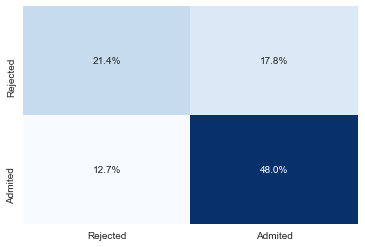

In [30]:
target_label = ['Rejected', 'Admited']
sns.heatmap(cnf, annot=True, fmt=".1%", cbar=False, cmap='Blues', xticklabels=target_label, yticklabels=target_label)

In [32]:
from sklearn.metrics import classification_report#presicion la presicion, f1-1 media armonica entre precision y recall
print(classification_report(y_test, nb_class_pred))# metricas reportadas condicen lo anterior

              precision    recall  f1-score   support

           0       0.63      0.55      0.58       533
           1       0.73      0.79      0.76       825

   micro avg       0.69      0.69      0.69      1358
   macro avg       0.68      0.67      0.67      1358
weighted avg       0.69      0.69      0.69      1358



In [34]:
pr1_nb = nb_prob_pred[:,1]

In [37]:
fpr, tpr, _ = roc_curve(y_test, pr1_nb) #fpt = falsos positivos , tpr = verdaderos positivos
auc = round(roc_auc_score(y_test,pr1_nb),3)

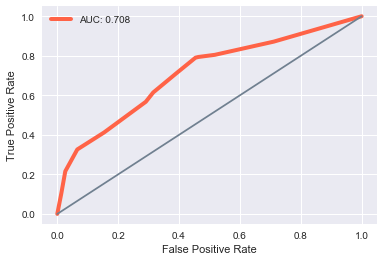

In [38]:
plt.plot(fpr, tpr, label="AUC: {}".format(auc), color='tomato', lw=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1], [0,1], color='slategrey')
plt.legend()

In [39]:
#evaluar que tan idoneo,es el modelo y su capacidad predictiva, se tranforma en un clasificador aleatorio por chance

In [40]:
#1 / clases por vector objetivo = al estar con 2 variables, la capidad de de obtener una etiqueta al azar es del 50%, nuestro benchmark nos entrega 0,708 por lo tanto es un 20% mejor que elegir al azar

In [42]:
np.exp(nb_classifier.class_log_prior_).round(2) #verisimilitud de ocurrencia

array([0.39, 0.61])

In [43]:
df_deagg['Admit'].value_counts('%').round(2)

1    0.61
0    0.39
Name: Admit, dtype: float64

In [46]:
afx.compare_priors(X_train, X_test, y_train, y_test, [0.39 , 0.61])

A priori: [0.39, 0.61]
Accuracy: 0.694
Recall: 0.79
Precision: 0.729
F1: 0.759
AUC: 0.708



In [47]:
afx.compare_priors(X_train, X_test, y_train, y_test, [0.5 , 0.5])

A priori: [0.5, 0.5]
Accuracy: 0.672
Recall: 0.713
Precision: 0.738
F1: 0.725
AUC: 0.708



In [49]:
#se ve empeoramiento en el modelo al ser 50/50, perdemos una perdida en la taza general

In [50]:
afx.compare_priors(X_train, X_test, y_train, y_test, [0.17 , 0.83])

A priori: [0.17, 0.83]
Accuracy: 0.643
Recall: 0.872
Precision: 0.655
F1: 0.748
AUC: 0.708

